In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import sys,os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [7]:
## Steps of data processing
# 1. data analysis
# 2. transform data to proper form (e.g, str to int)
# 3. splitting
# 4. scaling/standardizing (optional for now)
# 5. ...

In [8]:
df = pd.read_csv('../data/training_data_fall2024.csv')
df.head()

,hour_of_day,day_of_week,month,holiday,weekday,summertime,temp,dew,humidity,precip,snow,snowdepth,windspeed,cloudcover,visibility,increase_stock
0,5,5,1,0,0,0,-7.2,-15.0,53.68,0.0,0,0.0,16.3,31.6,16.0,low_bike_demand
1,21,4,1,0,1,0,-1.3,-12.8,40.97,0.0,0,0.0,23.9,85.7,16.0,low_bike_demand
2,21,3,8,0,1,1,26.9,21.8,73.39,0.0,0,0.0,0.0,81.1,16.0,low_bike_demand
3,1,6,1,0,0,0,3.1,-4.0,59.74,0.0,0,0.0,19.2,0.0,16.0,low_bike_demand
4,17,0,3,0,1,0,11.7,-11.4,18.71,0.0,0,0.0,10.5,44.6,16.0,low_bike_demand


In [9]:
# Checking types
df.dtypes

hour_of_day         int64
day_of_week         int64
month               int64
holiday             int64
weekday             int64
summertime          int64
temp              float64
dew               float64
humidity          float64
precip            float64
snow                int64
snowdepth         float64
windspeed         float64
cloudcover        float64
visibility        float64
increase_stock     object
dtype: object

In [10]:
# Checking the non-numerical types
values = df['increase_stock'].value_counts()
print(values)
print(f'Low bike demand precentage: {values[0]/values.sum():.2%}')

increase_stock
low_bike_demand     1312
high_bike_demand     288
Name: count, dtype: int64
Low bike demand precentage: 82.00%


In [11]:
# Check NA values
df.isna().sum()

hour_of_day       0
day_of_week       0
month             0
holiday           0
weekday           0
summertime        0
temp              0
dew               0
humidity          0
precip            0
snow              0
snowdepth         0
windspeed         0
cloudcover        0
visibility        0
increase_stock    0
dtype: int64

In [12]:
# Checking the value ranges for numerical features
df.describe()

,hour_of_day,day_of_week,month,holiday,weekday,summertime,temp,dew,humidity,precip,snow,snowdepth,windspeed,cloudcover,visibility
count,1600.00000,1600.000000,1600.000000,1600.000000,1600.000000,1600.00000,1600.000000,1600.000000,1600.000000,1600.000000,1600.0,1600.000000,1600.000000,1600.000000,1600.000000
mean,11.37125,3.022500,6.468750,0.033125,0.710000,0.64375,15.210313,7.750750,63.927844,0.122042,0.0,0.042713,13.082500,64.322375,15.344125
std,6.94837,2.012965,3.454741,0.179019,0.453904,0.47904,9.264785,10.026459,19.079419,0.920600,0.0,0.421198,7.756652,32.748869,2.323737
min,0.00000,0.000000,1.000000,0.000000,0.000000,0.00000,-9.100000,-18.400000,15.850000,0.000000,0.0,0.000000,0.000000,0.000000,0.100000
25%,5.00000,1.000000,3.000000,0.000000,0.000000,0.00000,7.700000,-0.800000,47.845000,0.000000,0.0,0.000000,7.500000,28.800000,16.000000
50%,12.00000,3.000000,6.000000,0.000000,1.000000,1.00000,15.500000,8.300000,65.175000,0.000000,0.0,0.000000,12.300000,79.300000,16.000000
75%,17.00000,5.000000,9.000000,0.000000,1.000000,1.00000,23.200000,16.800000,79.955000,0.000000,0.0,0.000000,17.600000,92.800000,16.000000
max,23.00000,6.000000,12.000000,1.000000,1.000000,1.00000,35.600000,24.300000,99.890000,25.871000,0.0,6.710000,43.800000,100.000000,16.000000


We saw that:
- we only have one non-numerical column, which is also the target column
    - it only has 2 values: 'low_bike_demand', 'high_bike_demand'
    - it is unbalanced
- the numerical features are in similar ranges (0-100)

Next steps:
- change target column values into 1 (high) and 0 (low)
- plot some interesting combinations of the features

In [13]:
# Change target column
df['increase_stock'] = df['increase_stock'].map({"high_bike_demand":1, "low_bike_demand":0})
df['increase_stock'].tail()

1595    0
1596    0
1597    0
1598    1
1599    0
Name: increase_stock, dtype: int64

## Plotting the **time** features vs the **demand**

In [14]:
## function for easier groupping
def get_high_demanc_prec(df: pd.DataFrame, column: str) -> pd.Series:
    # get the overall count, in the groups
    all_demand_count = df.loc[:, [column, 'increase_stock']].groupby(column).count()

    # get only the counts, where there was a high demand
    high_demand_count = df.loc[df['increase_stock']==1, [column, 'increase_stock']].groupby(column).count()
    
    # get a precentage
    high_demand_count_prec = high_demand_count / all_demand_count * 100
    return high_demand_count_prec

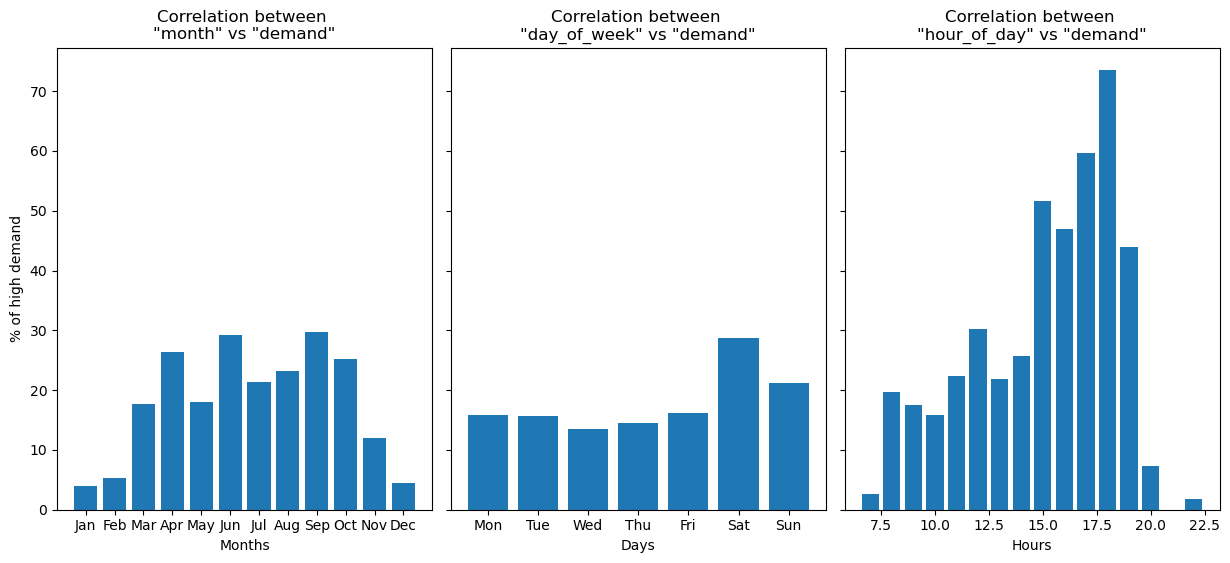

In [15]:
## Plot time periods vs demand

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6), sharey=True)

# Plot month demand
high_demand_count_prec = get_high_demanc_prec(df, 'month')
months = [datetime.datetime.strptime(str(m), '%m').strftime('%b') for m in high_demand_count_prec.index]
axes[0].bar(months, high_demand_count_prec['increase_stock'])
axes[0].set_title('Correlation between \n"month" vs "demand"')
axes[0].set_xlabel('Months')
axes[0].set_ylabel('% of high demand')

# Plot day_of_week demand
high_demand_count_prec = get_high_demanc_prec(df, 'day_of_week')
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1].bar(days, high_demand_count_prec['increase_stock'])
axes[1].set_title('Correlation between \n"day_of_week" vs "demand"')
axes[1].set_xlabel('Days')

# Plot hour_of_day demand
high_demand_count_prec = get_high_demanc_prec(df, 'hour_of_day')
axes[2].bar(high_demand_count_prec.index, high_demand_count_prec['increase_stock'])
axes[2].set_title('Correlation between \n"hour_of_day" vs "demand"')
axes[2].set_xlabel('Hours')

plt.subplots_adjust(wspace=0.05)
plt.show()

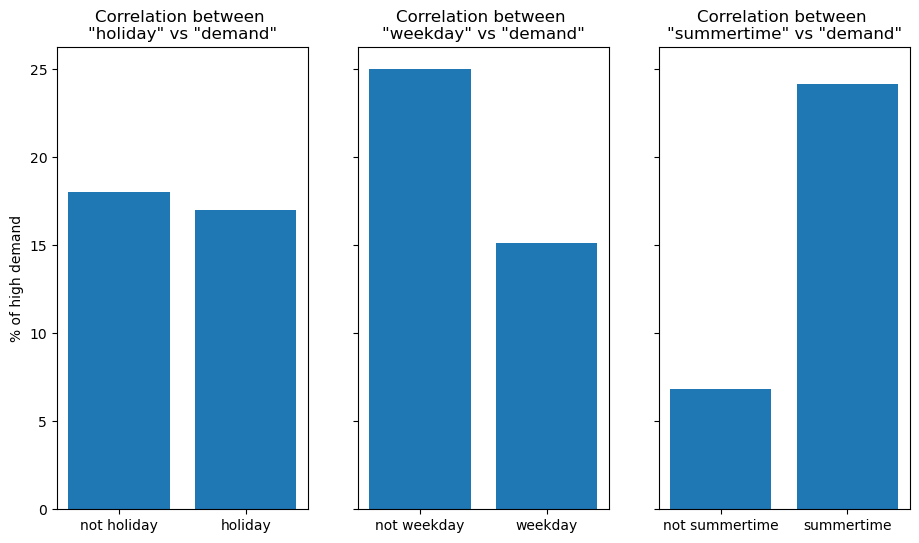

In [16]:
## Plot special times vs demand

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 6), sharey=True)

# Plot holiday demand
high_demand_count_prec = get_high_demanc_prec(df, 'holiday')
axes[0].bar(high_demand_count_prec.index, high_demand_count_prec['increase_stock'])
axes[0].set_title('Correlation between \n"holiday" vs "demand"')
axes[0].set_xticks(ticks=[0,1], labels=['not holiday', 'holiday'])
axes[0].set_ylabel('% of high demand')


# Plot weekday demand
high_demand_count_prec = get_high_demanc_prec(df, 'weekday')
axes[1].bar(high_demand_count_prec.index, high_demand_count_prec['increase_stock'])
axes[1].set_title('Correlation between \n"weekday" vs "demand"')
axes[1].set_xticks(ticks=[0,1], labels=['not weekday', 'weekday'])


# Plot summertime demand
high_demand_count_prec = get_high_demanc_prec(df, 'summertime')
axes[2].bar(high_demand_count_prec.index, high_demand_count_prec['increase_stock'])
axes[2].set_title('Correlation between \n"summertime" vs "demand"')
axes[2].set_xticks(ticks=[0,1], labels=['not summertime', 'summertime'])


plt.show()

## Plotting the **environment** features vs the **demand**

In [17]:
hist_colors = ['mediumseagreen', 'orangered']

def separate_data(df:pd.DataFrame, column:str, include_zero_values=True):
    plt_df = df
    if not include_zero_values:
        plt_df = df.loc[df[column]!=0]

    low_demand = plt_df.loc[df['increase_stock']==0, column]
    high_demand = plt_df.loc[df['increase_stock']==1, column]

    return low_demand, high_demand


def plot_hist(low_demand:pd.Series, high_demand:pd.Series, column:str, xlabel:str, bins=20):
    bins = np.histogram(np.hstack((low_demand,high_demand)), bins=bins)[1]
    plt.hist([low_demand, high_demand], bins, color=hist_colors)
    plt.title(f'Correlation between \n"{column}" vs "demand"')
    plt.legend(['Low demand', 'High demand'])
    plt.xlabel(xlabel)
    plt.ylabel('# of days with certain demand')
    plt.show()

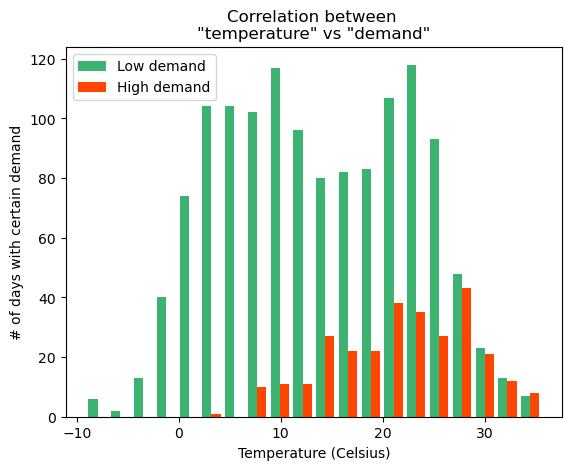

In [18]:
# Plot temp demand
high_demand_temp = df.loc[df['increase_stock']==1, 'temp']
low_demand_temp = df.loc[df['increase_stock']==0, 'temp']

bins = np.histogram(np.hstack((low_demand_temp,high_demand_temp)), bins=20)[1]
plt.hist([low_demand_temp, high_demand_temp], bins, color=hist_colors)
plt.title('Correlation between \n"temperature" vs "demand"')
plt.legend(['Low demand', 'High demand'])
plt.xlabel('Temperature (Celsius)')
plt.ylabel('# of days with certain demand')
plt.show()

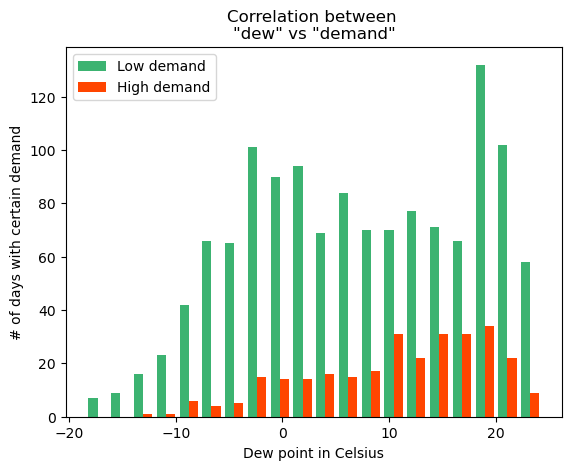

In [19]:
# Plot dew demand
## TODO: explain dew point
## TODO: plot with tempearture

high_demand_temp = df.loc[df['increase_stock']==1, 'dew']
low_demand_temp = df.loc[df['increase_stock']==0, 'dew']

bins = np.histogram(np.hstack((low_demand_temp,high_demand_temp)), bins=20)[1]
plt.hist([low_demand_temp, high_demand_temp], bins, color=hist_colors)
plt.title('Correlation between \n"dew" vs "demand"')
plt.legend(['Low demand', 'High demand'])
plt.xlabel('Dew point in Celsius')
plt.ylabel('# of days with certain demand')
plt.show()

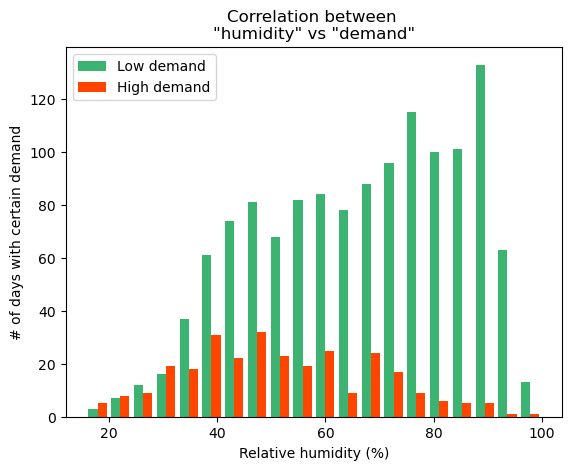

In [20]:
# Plot humidity demand
column = 'humidity'

low_demand, high_demand = separate_data(df, column)
plot_hist(low_demand, high_demand, column, 'Relative humidity (%)')

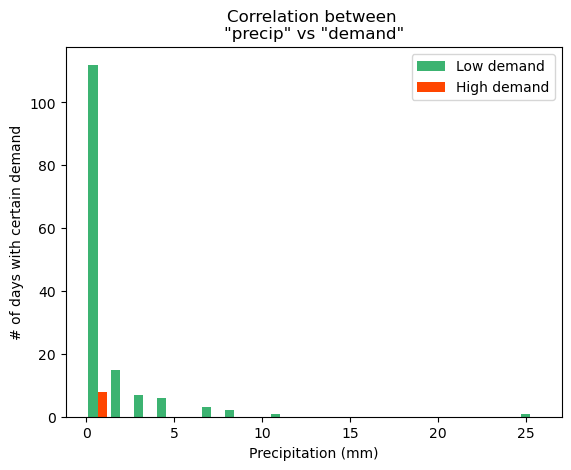

In [21]:
# Plot precip demand
INCLUDE_ZERO = False 
column = 'precip'

low_demand, high_demand = separate_data(df, column, INCLUDE_ZERO)
plot_hist(low_demand, high_demand, column, 'Precipitation (mm)')

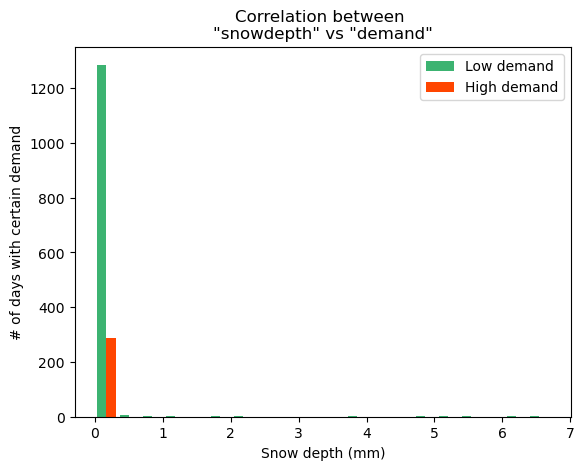

In [22]:
# Plot snowdepth demand
INCLUDE_ZERO = True
column = 'snowdepth'

low_demand, high_demand = separate_data(df, column, INCLUDE_ZERO)
plot_hist(low_demand, high_demand, column, 'Snow depth (mm)')

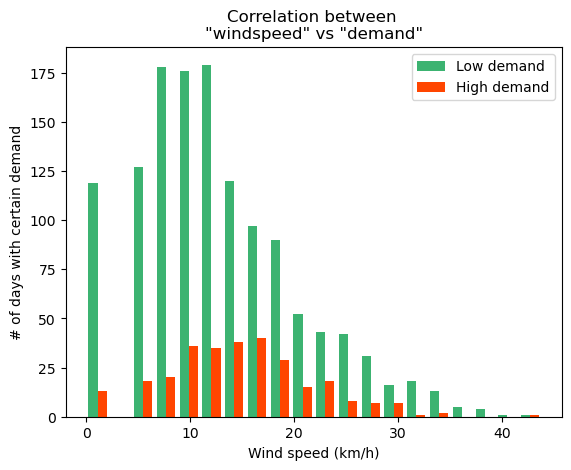

In [23]:
# Plot windspeed demand
column = 'windspeed'

low_demand, high_demand = separate_data(df, column)
plot_hist(low_demand, high_demand, column, 'Wind speed (km/h)')

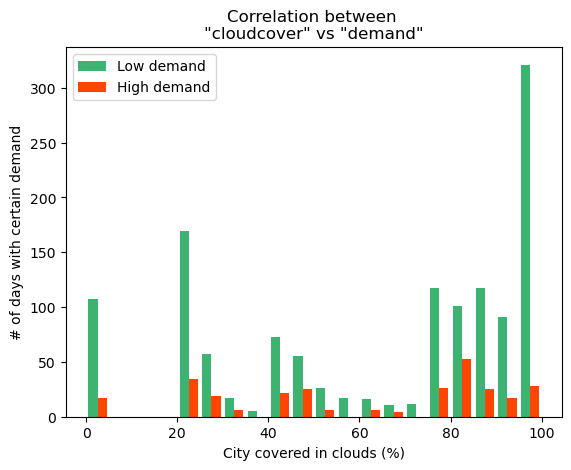

In [24]:
# Plot cloudcover demand
column = 'cloudcover'

low_demand, high_demand = separate_data(df, column)
plot_hist(low_demand, high_demand, column, 'City covered in clouds (%)')

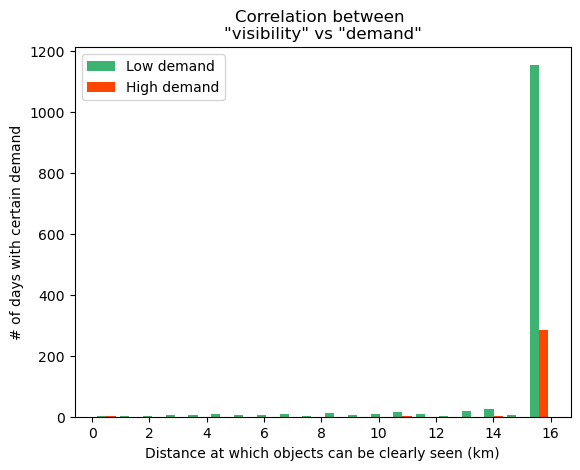

In [25]:
# Plot visibility demand
column = 'visibility'

low_demand, high_demand = separate_data(df, column)
plot_hist(low_demand, high_demand, column, 'Distance at which objects can be clearly seen (km)')

### Insights && Question answers:

1. Temperature:
    - Warm temperatures (>15 Celsius) strongly correlate with high demand.
2. Dew point:
    - It seems the negative values correlate with less demand.
3. Humidity:
    - Its clearly visible, that as the humidity goes higher from 50% onwards the demand goes down.
4. Precipitation:
    - Most of the values are 0, this feature might not help our models too much.
    - ***TODO***: try to remove the feature, and see if it changes the result
5. Amount of snow in last hour:
    - The only value is 0, so this feature will be dropped.
6. Snow depth:
    - Most of the values are 0, which is not suprising. Most likely this feature will not give much information for the models.
    - ***TODO***: try to remove the feature, and see if it changes the result
7. Wind speed:
    - There seems to be a correlation with the demand. We can see that the demand rises between 15-20 km/h windspeed, and the when the speed is lower than this there lower bike demand.
8. Cloud coverage:
    - Unfortunately, the plot doesn't tell us a lot about this feature, except maybe that there is usually a high cloud coverage in the city.
    - ***TODO***: analyse this feature a bit more
9. Visibility:
    - Most of the data has the value of 16.0, meaning the visibility was perfect on most days. Unfortunately, this most likely means that it won't be beneficial for our models, as we won't gain too much information from this feature.
    - ***TODO***: try to remove the feature, and see if it changes the result
    - ***TODO***: check the correlation with "Cloud coverage"

***TODO***: it is highly likely that most of the environment features correlate with each other, this could impact the training negatively
    - ***TODO***: check correlations
***TODO***: check outliers for most features (box plot for visualizing distribution)

## Processing the data

Steps to take:

1. **Convert** non-numerical column to numerical types
2. *[Create new features && Drop useless features]* 
3. Shuffle && **Split** data into train, [valid], test sets
4. *[Scale data (normalization, standardization)]*

Problems:

1. The dataset is unbalanced (there is huge amount of low demand, while not a lot of high demand)
    - Which models work best with unbalanced dataset?
    - What are ways to make the dataset more balanced?

In [26]:
## 1. Convert to numerical
processed_df = df.copy()

# map the target column to 1/0 (if not already)
if processed_df['increase_stock'].dtype is not np.int64:
    processed_df['increase_stock'] = processed_df['increase_stock'].map({"high_bike_demand":1, "low_bike_demand":0})

processed_df.head()

,hour_of_day,day_of_week,month,holiday,weekday,summertime,temp,dew,humidity,precip,snow,snowdepth,windspeed,cloudcover,visibility,increase_stock
0,5,5,1,0,0,0,-7.2,-15.0,53.68,0.0,0,0.0,16.3,31.6,16.0,NaN
1,21,4,1,0,1,0,-1.3,-12.8,40.97,0.0,0,0.0,23.9,85.7,16.0,NaN
2,21,3,8,0,1,1,26.9,21.8,73.39,0.0,0,0.0,0.0,81.1,16.0,NaN
3,1,6,1,0,0,0,3.1,-4.0,59.74,0.0,0,0.0,19.2,0.0,16.0,NaN
4,17,0,3,0,1,0,11.7,-11.4,18.71,0.0,0,0.0,10.5,44.6,16.0,NaN


In [27]:
## 2. Create and drop features

# Drop snow (it only has 0 values -> no information)
processed_df.drop('snow', axis=1, inplace=True)

# Add new (derived/composite) features
# TODO

In [28]:
## 3. Shuffle and split


SEED = 1
def split(df:pd.DataFrame, prec:dict, info=False):
    # setting and checking parameters
    if sum(prec.values()) != 1.0:
        raise ValueError(f'Split precentages do not add up to 1.0! Precentages: {prec.values()}')

    # shuffling
    data = df.sample(frac=1, random_state=SEED, ignore_index=True)
    
    splits = []
    split_start_index = 0
    data_size = data.shape[0]
    for split_name, p in prec.items():
        # calculate current split's end index
        split_size = data_size * p
        split_end_index = int(split_start_index + split_size if split_start_index + split_size < data_size else data_size)
        
        if info: print(f'{split_name} -> range=[{split_start_index}-{split_end_index-1}] size={split_end_index-split_start_index}')
        
        # get data for current split
        split_data = data.iloc[split_start_index:split_end_index]
        splits.append(split_data)

        # set the next split's start
        split_start_index = split_end_index


    return splits


from sklearn.preprocessing import MinMaxScaler

#df_scaled = df.copy()
#df_scaled.iloc[:, :] = MinMaxScaler().fit_transform(df)
#df = df_scaled

prec = {
    'train': 0.8,
    'test': 0.2
}
splits = split(df, prec=prec, info=True)

# separate the target and the data
for name, split_set in zip(prec.keys(), splits):
    match name:
        case 'train':
            X_train, Y_train = split_set.iloc[:,:-1], split_set.iloc[:,-1]
        case 'val':
            X_val, Y_val = split_set.iloc[:,:-1], split_set.iloc[:,-1]
        case 'test':
            X_test, Y_test = split_set.iloc[:,:-1], split_set.iloc[:,-1]
        case _:
            raise ValueError(f'{name} is not accepted as a key, please use either "train", "val" or "test"!')

train -> range=[0-1279] size=1280
test -> range=[1280-1599] size=320


In [29]:
## 4. Scale data
# Some models are really sensitive to the range of the features, so it's sometimes beneficial to scale every feature's range.

import sys
sys.path.append(os.path.abspath(".."))

# TODO
from process_data import process_data


X_train, X_test, Y_train , Y_test = process_data(split_prec=prec)

X_train

Dropped columns: ['snow']
New columns: ['good_weather' 'is_day' 'temp_fahrenheit']
Split: "train" 	[Size: 1280] 	[Prec: 0.8]
	X: (1280, 17)
	Y: (1280,)
Split: "test" 	[Size: 320] 	[Prec: 0.2]
	X: (320, 17)
	Y: (320,)


,hour_of_day,day_of_week,month,holiday,weekday,summertime,temp,dew,humidity,precip,snowdepth,windspeed,cloudcover,visibility,temp_fahrenheit,good_weather,is_day
0,0.652174,0.166667,0.272727,0.0,1.0,1.0,0.764574,0.728337,0.361495,0.000000,0.0,0.415525,0.244,1.000000,0.7625,0.800271,1.0
1,0.000000,0.000000,0.545455,0.0,1.0,1.0,0.807175,0.948478,0.704783,0.000000,0.0,0.226027,0.244,1.000000,0.8000,0.931861,0.0
2,0.826087,0.333333,0.818182,0.0,1.0,1.0,0.672646,0.847775,0.793789,0.000000,0.0,0.166667,0.813,1.000000,0.6750,0.838440,0.0
3,0.000000,1.000000,0.454545,0.0,0.0,1.0,0.757848,0.922717,0.760709,0.004832,0.0,0.280822,0.960,0.830189,0.7500,0.901958,0.0
4,0.869565,0.166667,0.727273,0.0,1.0,1.0,0.612108,0.531616,0.285935,0.000000,0.0,0.299087,0.280,1.000000,0.6125,0.650974,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,1.000000,0.833333,0.636364,0.0,0.0,1.0,0.683857,0.861827,0.797120,0.000000,0.0,0.347032,0.813,1.000000,0.6875,0.845951,0.0
1276,0.000000,0.833333,1.000000,0.0,0.0,0.0,0.282511,0.426230,0.720609,0.000000,0.0,0.000000,0.000,1.000000,0.2750,0.317173,0.0
1277,0.304348,0.333333,0.727273,0.0,1.0,1.0,0.713004,0.927400,0.892075,0.000000,0.0,0.205479,0.589,1.000000,0.7125,0.891920,0.0
1278,0.478261,0.500000,0.181818,0.0,1.0,1.0,0.426009,0.637002,0.914802,0.002126,0.0,0.253425,1.000,0.981132,0.4250,0.648902,1.0


In [31]:
# preproccessing of target features

import sklearn.discriminant_analysis as skl_da
from mlxtend.feature_selection import ExhaustiveFeatureSelector

training_category = [
    "hour_of_day",
    "day_of_week",
    "month",
    "holiday",
    "weekday",
    "summertime",
    "temp",
    "dew",
    "humidity",
    "precip",
    #"snow",
    #"snowdepth",
    "windspeed",
    "cloudcover",
    "visibility",
    #temp_fahrenheit",
    #good_weather",
    #is_day"

]


training_category = ['hour_of_day', 'weekday', 'temp', 'humidity', 'windspeed'] #best features for qda
#training_category = ['month', 'holiday', 'weekday', 'summertime', 'temp', 'humidity', 'precip'] #best features for lda

X_train_selected = X_train[training_category]

X_test_selected = X_test[training_category]


lda = skl_da.LinearDiscriminantAnalysis()
qda = skl_da.QuadraticDiscriminantAnalysis()




# Exhaustive search to find out the best features
efs = ExhaustiveFeatureSelector(
    estimator= qda,
    min_features=1,
    max_features=len(training_category),
    scoring='accuracy',  
    cv=5,                
)

# Fit to the data
efs = efs.fit(X_train[training_category], Y_train)


# Get the best feature combination
best_features = list(efs.best_feature_names_)
print(f"Best feature combination: {best_features}")

c:\Users\caleb\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\caleb\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\caleb\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\caleb\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Best feature combination: ['hour_of_day', 'weekday', 'temp', 'humidity', 'windspeed']


In [32]:
#Training of the LDA model
import evaluate

lda.fit(X = X_train_selected,y = Y_train)
lda_predic_prob = lda.predict(X = X_test_selected)

results = evaluate.evaluate_pred(lda_predic_prob,Y_test)

print("Accuracy of LDA:", results["accuracy"])
print("Recall of LDA:", results["recall"])
print("Precision of LDA:", results["precision"])











Accuracy of LDA: 0.86875
Recall of LDA: 0.52
Precision of LDA: 0.5909090909090909


c:\Users\caleb\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [33]:
# Training of the QDA model


qda.fit(X = X_train_selected,y = Y_train)
qda_predic_prob = qda.predict(X = X_test_selected)


results = evaluate.evaluate_pred(qda_predic_prob,Y_test)

print("Accuracy of QDA:", results["accuracy"])
print("Recall of QDA:", results["recall"])
print("Precision of QDA:", results["precision"])









Accuracy of QDA: 0.9
Recall of QDA: 0.68
Precision of QDA: 0.68


c:\Users\caleb\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [34]:
#knn

import sklearn.neighbors as skl_n
knn = skl_n.KNeighborsClassifier()

knn.fit(X = X_train_selected,y = Y_train)
qda_predic_prob = knn.predict(X = X_test_selected)

#print("confusion matrix for knn")
#print(pd.crosstab(qda_predic_prob,Y_test))
#print(f"Accuracy: {np.mean(qda_predic_prob == Y_test):.3f}")



c:\Users\caleb\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [35]:
#decision tree classifier

import sklearn.tree as skl_tree


dtc = skl_tree.DecisionTreeClassifier()

dtc.fit(X = X_train_selected,y = Y_train)
qda_predic_prob = dtc.predict(X = X_test_selected)

#print("confusion matrix for knn")
#print(pd.crosstab(qda_predic_prob,Y_test))
#print(f"Accuracy: {np.mean(qda_predic_prob == Y_test):.3f}")

In [36]:
#Traing of QDA with K-fold validation

from sklearn.model_selection import cross_val_score



scores = cross_val_score(qda, X_train_selected, Y_train, cv=5, scoring='accuracy')
print("k-fold scores")
print(np.mean(scores))

X_combined = pd.concat([X_train_selected, X_test_selected], axis=0, ignore_index=True)
Y_combined = pd.concat([Y_train, Y_test], axis=0, ignore_index=True)





qda.fit(X = X_combined,y = Y_combined)
qda_predic_prob = qda.predict(X = X_test_selected)
#print("confusion matrix for qda")
#print(pd.crosstab(qda_predic_prob,Y_test))
#print(f"Accuracy: {np.mean(qda_predic_prob == Y_test):.3f}")




k-fold scores
0.87109375


c:\Users\caleb\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\caleb\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\caleb\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\caleb\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

In [37]:


#correlation of the features
training_category = [
    "hour_of_day",
    "day_of_week",
    "month",
    "holiday",
    "weekday",
    "summertime",
    "temp",
    "dew",
    "humidity",
    "precip",
    #"snow",
    "snowdepth",
    "windspeed",
    "cloudcover",
    "visibility",
    "temp_fahrenheit",
    "good_weather",
    "is_day"

]
X_train

corr_matrix = X_train[training_category].corr()

# Display pairs of highly correlated features
print(corr_matrix[corr_matrix > 0])

                 hour_of_day  day_of_week     month   holiday   weekday  \
hour_of_day         1.000000     0.022983       NaN  0.002069       NaN   
day_of_week         0.022983     1.000000       NaN       NaN       NaN   
month                    NaN          NaN  1.000000       NaN  0.043589   
holiday             0.002069          NaN       NaN  1.000000  0.118565   
weekday                  NaN          NaN  0.043589  0.118565  1.000000   
summertime          0.030875     0.024386  0.056694       NaN       NaN   
temp                0.175883     0.010327  0.211986       NaN  0.004693   
dew                      NaN     0.014312  0.274493       NaN  0.010585   
humidity                 NaN     0.003204  0.166424       NaN  0.023297   
precip                   NaN          NaN       NaN       NaN  0.030105   
snowdepth                NaN          NaN       NaN       NaN  0.020208   
windspeed           0.185792     0.026866       NaN       NaN       NaN   
cloudcover          0.005